The goal of this program is to design a robot and write a control policy to move the robot to the desired point and a desired orientation

In [1]:
%pylab inline
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display    
from IPython.display import HTML
import math
import matplotlib.patches as patches

Populating the interactive namespace from numpy and matplotlib


## Euler Integration

In [2]:
def simulate(Δt,z,u):
    z = z + Δt*u
    return z

## Control Policy

In [3]:
def control(z,pos_ref,kp_kd,r,g,mass,dz,A,theta_ref):
    error = pos_ref - z
    xu = kp_kd[0]*error[0] + kp_kd[1]*error[3]
    zu = (kp_kd[0]*error[1] + kp_kd[1]*error[4] + mass*g)/mass-g
    thetaU = (kp_kd[0]*error[2] + kp_kd[1]*error[5])*(1/2*mass*r**2)
    wrench = np.array([xu,zu,thetaU])

    rotation = [[math.cos(theta_ref),math.sin(theta_ref),0],[math.sin(-theta_ref), math.cos(theta_ref),0],[0,0,1]]

    world_frame = np.dot(rotation,A)
    inv = np.linalg.inv(world_frame)
    u = np.dot(inv,wrench)
    
    a = np.dot(world_frame,u)
    dz[:3] = z[3:]
    dz[3:] = a

    return dz

## Vehicle Design

[[-0.99608784 -0.44807362  0.52532199]
 [ 0.08836869  0.89399666  0.85090352]
 [-0.32130655 -2.14988067 -1.43914605]]
The rank of the matrix is:  3


(-10.0, 20.0)

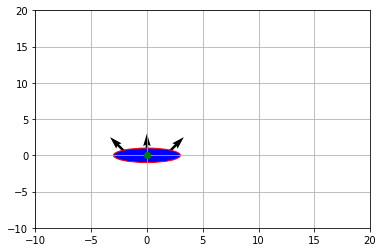

In [4]:
p1 = np.array([-2,0.5])
p2 = np.array([0,1])
p3 = np.array([2,0.5])
theta1 = 135
theta2 = 90
theta3 = 45

A = np.array([[math.cos(theta1),math.cos(theta2),math.cos(theta3)],[math.sin(theta1),math.sin(theta2),math.sin(theta3)],[math.cos(theta1)*p1[1]-math.sin(theta1)*p1[0],math.cos(theta2)*p2[1]-math.sin(theta3)*p3[0],math.cos(theta3)*p3[1]-math.sin(theta3)*p3[0]]])
print(A)
rank = np.linalg.matrix_rank(A)
print("The rank of the matrix is: ",rank)



fig, ax = plt.subplots()

q_x = [-2, 0,2]
q_z = [0.5,1,0.5]
x_direct = [-1,0,1]
z_direct = [1,1,1]


ell = patches.Ellipse((0,0),-6,2,ec='r',fc='b')

ax.quiver(q_x,q_z,x_direct,z_direct)
ax.add_patch(ell)
plt.plot(0,0,'go')
plt.grid()
ax.set_xlim(-10, 20)
ax.set_ylim(-10, 20)

#plt.show()


## Running the simulator

[0.         0.         0.1        0.28       0.523      0.8146
 1.14265    1.496944   1.8689527  2.25159022 2.63901071 3.0264312
 3.40997748 3.7865502  4.15370859 4.50956981 4.8527217  5.18214751
 5.49716094 5.79735021 6.08253002 6.35270036 6.60801134 6.84873311
 7.07523042 7.28794094 7.48735704 7.67401052 7.84845973 8.01127899
 8.16304981 8.30435367 8.43576626 8.5578528  8.67116436 8.77623509
 8.87358002 8.96369362 9.0470487  9.12409583 9.19526304 9.26095585
 9.32155747 9.37742921 9.42891103 9.47632219 9.519962   9.56011064
 9.59702992 9.63096424 9.6621414  9.69077349 9.71705774 9.74117741
 9.76330257 9.78359092 9.80218857 9.81923079 9.83484267 9.84913988
 9.86222921 9.87420928 9.88517104 9.89519836 9.9043685  9.91275263
 9.92041625 9.92741962 9.93381816 9.93966279 9.94500031 9.9498737
 9.95432241 9.95838264 9.9620876  9.96546774 9.96855098 9.97136289
 9.97392691 9.9762645  9.9783953  9.98033729 9.98210694 9.98371928
 9.98518808 9.98652593 9.98774433 9.98885379 9.98986392 9.99078348
 

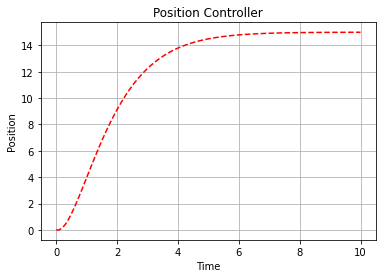

In [5]:
tf=10
Δt = 0.1  #Time Step
time = np.linspace(0.,tf,int(tf/Δt+1))

#Initialization
z = np.array([0.,0.,0.,0.,0.,0.])
z_log = [np.copy(z)]
dz = np.array([0.,0.,0.,0.,0.,0.])
theta_ref = (3*math.pi)/4
pos_ref = np.array([10,15,theta_ref,0,0,0])
r=1
g = 9.8
mass = 1
kp_kd = np.array([1.,2.])

for t in time[1:]:
    contrl = control(z,pos_ref,kp_kd,r,g,mass,dz,A,theta_ref)
    z = simulate(Δt,z,contrl)
    z_log.append(np.copy(z))
z_log = np.array(z_log)

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(time,z_log[:,1], 'r--')
plt.xlabel("Time")
plt.ylabel("Position")
plt.title("Position Controller")
plt.grid()

#print(z_log)
pos_x = z_log[:,0]
print(pos_x)
pos_z = z_log[:,1]
print(pos_z)
pos_theta = z_log[:,2]

## Animation

In [6]:
patch = patches.Ellipse((0,0),0,0,ec='b',fc='none',ls='--')

def init():
    ax.add_patch(patch)
    return patch,

def animate(i):
    
    patch.set_width(-6)
    patch.set_height(2)
    patch.set_center([pos_x[i], pos_z[i]])
    #patch.set_xy([0,0])
    patch.angle = np.rad2deg(pos_theta[i])
    #ax.clear()
    return patch,

anim = animation.FuncAnimation(fig, animate,init_func=init,frames=len(time),interval=150,blit=True)
HTML(anim.to_jshtml())